In [68]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [115]:
from skimage.io import imread, imsave, imshow
from skimage import img_as_float, img_as_ubyte
import numpy as np

In [70]:
im = imread('img.png')

In [71]:
def extend_height(original_image_shape, extended_image, width, height, addition = 0):
    for h in range(height - 1, -1, -1):
        for i in range(original_image_shape[1] + addition):
            extended_image[h, i + width] \
                = extended_image[h + 1 : h + 1 + height, i : i + height * 2 + 1].mean(axis=0).mean(axis=0)
            extended_image[-h - 1, i + width] \
                = extended_image[-h - 1 - height : -h - 1, i : i + height * 2 + 1].mean(axis=0).mean(axis=0)

In [72]:
def extend_width(original_image_shape, extended_image, width, height, addition = 0):
    for w in range(width - 1, -1, -1):
        for i in range(original_image_shape[0] + addition):
            extended_image[i + height, w] \
                = extended_image[i : i + height * 2 + 1, w + 1 : w + 1 + width].mean(axis = 0).mean(axis = 0)
            extended_image[i + height, -w - 1] \
                = extended_image[i : i + height * 2 + 1, -w - 1 - width : -w - 1].mean(axis = 0).mean(axis = 0)

In [73]:
def check_on_grey(image):
    is_grey = False
    if len(image.shape) < 3:
        is_grey = True
        image.shape = image.shape + (1,)
    return is_grey

In [157]:
def extend_image(image, width=1, height=1):
    dtype = image.dtype
    image = image.copy()
    is_grey = check_on_grey(image)
        
    fatting = width * image.shape[0] < height * image.shape[1]

    if fatting:
        width = 2 * width
    else:
        height = 2 * height

    extended_image = np.ones((image.shape[0] + height * 2, image.shape[1] + width * 2, image.shape[2]), dtype = dtype)
    extended_image[:] = 256 / 2
    extended_image[height : -height if height > 0 else None, width : -width if width > 0 else None] = image
    
    if fatting:
        extend_width(image.shape, extended_image, width, height)
        width = int(width / 2)
        extend_height(image.shape, extended_image, width, height, width * 2)
        resolved_image = extended_image[ : , width : -width if width > 0 else None]
    else:
        extend_height(image.shape, extended_image, width, height)
        height = int(height / 2)
        extend_width(image.shape, extended_image, width, height, height * 2)
        resolved_image = extended_image[height : -height if height > 0 else None, : ]
        
    if is_grey:
        return resolved_image[...,0]
    else:
        return resolved_image

In [75]:
def filter_box(image, width=3, height=3):
    image = image.copy()
    is_grey = check_on_grey(image)
        
    side_extension = int(width / 2)
    vert_extension = int(height / 2)
    extended_image = extend_image(image, side_extension, vert_extension)
    res = np.zeros(image.shape, dtype=np.uint8)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            for k in range(image.shape[2]):
                r = extended_image[i : i + height, j : j + width, k].mean()
                res[i, j, k] = r
    if is_grey:
        return res[...,0]
    else:
        return res

In [76]:
def filter_median(image, width=3, height=3):
    image = image.copy()
    is_grey = check_on_grey(image)
    side_extension = int(width / 2)
    vert_extension = int(height / 2)
    extended_image = extend_image(image, side_extension, vert_extension)
    res = np.zeros(image.shape, dtype=np.uint8)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            for k in range(image.shape[2]):
                r = np.median(extended_image[i : i + height, j : j + width, k])
                res[i, j, k] = r
    if is_grey:
        return res[...,0]
    else:
        return res

In [166]:
def filter_convolution(image, conv):
    dtype = image.dtype
    image = image.copy()
    is_grey = check_on_grey(image)
    csum = conv.sum()
    if csum == 0:
        csum = 1
    width = conv.shape[1]
    height = conv.shape[0]
    side_extension = int(width / 2)
    vert_extension = int(height / 2)
    extended_image = extend_image(image, side_extension, vert_extension)
    res = np.zeros(image.shape, dtype=dtype)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            for k in range(image.shape[2]):
                res[i, j, k] = (extended_image[i : i + height, j : j + width, k] * conv).sum() / csum
    if is_grey:
        return res[...,0]
    else:
        return res

In [78]:
def filter_gaussian(image, n):
    m = np.arange(n)
    mu = (n - 1) / 2
    sigma = mu / 3
    hres = (1 / ((2 * np.pi * sigma ** 2) ** .5)) * np.exp(-((m - mu) ** 2)
                                                        /#------------------
                                                          (2 * sigma ** 2))
    vres = hres.copy()
    hres.shape = (n, 1)
    vres.shape = (1, n)
    hf = filter_convolution(image, hres)
    res = filter_convolution(hf, vres)
    return res

In [102]:
def rgb2gray(rgb):
    single = np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140]).astype(np.uint8)
    return single

In [211]:
def wrap_edge_filters(image, filter_convs, blur_method = None):
    is_grey = check_on_grey(image)
    if not is_grey:        
        grey = rgb2gray(image)
    else:
        grey = image.copy()
    if blur_method is not None:
        try:
            grey = blur_method(image)
        except:
            print('blur method failed')
            pass
    grey = img_as_float(grey)
    yed = filter_convolution(grey, filter_convs[0])
    xed = filter_convolution(grey, filter_convs[1])
    res = np.sqrt(np.square(yed) + np.square(xed))
    res = np.clip(res, 0, 1)
    res = img_as_ubyte(res)
    gradient = np.arctan2(yed, xed)
    return res, gradient 

In [198]:
def filter_prewitt_obsolete(image, blur_method = None):
    is_grey = check_on_grey(image)
    if not is_grey:        
        grey = rgb2gray(image)
    else:
        grey = image.copy()
    if blur_method is not None:
        try:
            grey = blur_method(image)
        except:
            print('blur method failed')
            pass
    grey = img_as_float(grey)
    operator_y = np.array(((1,1,1),(0,0,0),(-1,-1,-1)))
    yed = filter_convolution(grey, operator_y)
    operator_x = np.array(((1,0,-1),(1,0,-1),(1,0,-1)))
    xed = filter_convolution(grey, operator_x)
    res = np.sqrt(np.square(yed) + np.square(xed))
    res = np.clip(res, 0, 1)
    res = img_as_ubyte(res)
    gradient = np.arctan2(yed, xed)
    return res, gradient

In [221]:
def filter_prewitt(image, blur_method = None):
    operator_y = np.array(((1,1,1),(0,0,0),(-1,-1,-1)))
    operator_x = np.array(((1,0,-1),(1,0,-1),(1,0,-1)))
    return wrap_edge_filters(image, (operator_y, operator_x), blur_method)

In [218]:
def filter_roberts(image, blur_method = None):
    operator_y = np.array(((1,0),(0,-1)))
    operator_x = np.array(((0,1),(-1,0)))
    return wrap_edge_filters(image, (operator_y, operator_x), blur_method)

In [222]:
def filter_sobel(image, blur_method = None):
    operator_y = np.array(((-1,-2,-1),(0,0,0),(1,2,1)))
    operator_x = np.array(((-1,0,1),(-2,0,2),(-1,0,1)))
    return wrap_edge_filters(image, (operator_y, operator_x), blur_method)

In [32]:
wah_robers = filter_roberts(im)

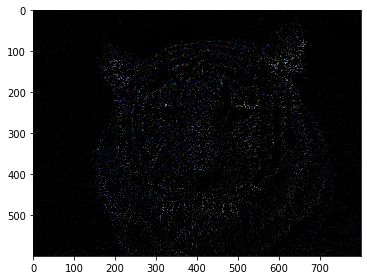

In [33]:
imshow(wah_robers)

In [34]:
imsave('roberts.png', wah_robers)

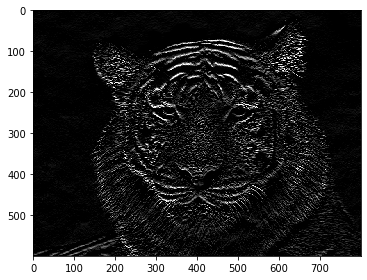

In [25]:
imshow(wah)

In [89]:
gauss3 = filter_gaussian(im, 3)

In [90]:
imsave('gauss3.png', gauss3)

In [95]:
gauss7 = filter_gaussian(im, 7)

In [96]:
imsave('gauss7.png', gauss7)

In [91]:
box3 = filter_box(im)

In [92]:
imsave('box3.png', box3)

In [167]:
prewitt = filter_prewitt(im)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


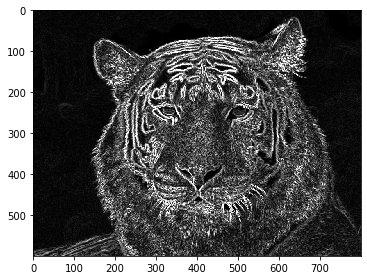

In [170]:
imshow(prewitt)

In [171]:
w = imread('swatch.jpg_large')

In [178]:
wedge, gr = filter_prewitt(w)

In [175]:
imsave('wedged.jpg', wedge)

In [183]:
face = imread('face.jpg')

In [185]:
edgy_one = filter_prewitt(face)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [189]:
_, gface = filter_prewitt(face)

In [190]:
imsave('gface.png', gface)

Lossy conversion from float64 to uint8. Range [-3.141592653589793, 3.141592653589793]. Convert image to uint8 prior to saving to suppress this warning.


In [191]:
miku = imread('miku.jpg')

In [192]:
e_miku, g_miku = filter_prewitt(miku)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [193]:
imsave('eMiku.png', e_miku)
imsave('gMiku.png', g_miku)

Lossy conversion from float64 to uint8. Range [-3.141592653589793, 3.141592653589793]. Convert image to uint8 prior to saving to suppress this warning.


In [199]:
b_e_miku, _ = filter_prewitt(miku, filter_box)

was here!


C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [200]:
imsave('beMiku.png', b_e_miku)

In [201]:
b_e_miku

array([[[255, 255, 255],
        [255, 255, 255],
        [ 25,  22,  22],
        ...,
        [  1,   2,   6],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [ 30,  26,  26],
        [ 17,  14,  14],
        ...,
        [  0,   1,   6],
        [  4,   3,   9],
        [255, 255, 255]],

       [[ 26,  23,  23],
        [ 23,  19,  19],
        [ 13,  10,  12],
        ...,
        [  0,   1,   7],
        [  1,   3,   6],
        [  2,   2,   2]],

       ...,

       [[ 14,  14,  14],
        [ 13,  13,  13],
        [  3,   4,   4],
        ...,
        [ 18,  14,  11],
        [ 16,  11,  10],
        [ 12,   6,   3]],

       [[255, 255, 255],
        [ 23,  22,  22],
        [  9,  11,  11],
        ...,
        [ 15,  13,  11],
        [ 15,  16,  17],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [ 15,  17,  17],
        ...,
        [  3,   7,   9],
        [255, 255, 255],
        [255, 255, 255]]

In [202]:
e_miku

array([[255, 255,  32, ...,   3, 255, 255],
       [255,  13,  24, ...,   3,   1, 255],
       [ 20,  27,  16, ...,   3,   3,   3],
       ...,
       [ 19,  23,  16, ...,  17,  14,  12],
       [255,   9,  22, ...,  18,  17, 255],
       [255, 255,  25, ...,  10, 255, 255]], dtype=uint8)

In [205]:
b_e_face, _ = filter_prewitt(face, filter_box)

was here!


C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [206]:
imsave('beFace.png', b_e_face)

In [219]:
w_e_roberts, w_g_roberts = filter_roberts(w)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [220]:
imsave('weRoberts.png', w_e_roberts)
imsave('wgRoberts.png', w_g_roberts)

Lossy conversion from float64 to uint8. Range [-3.141592653589773, 3.141592653589793]. Convert image to uint8 prior to saving to suppress this warning.


In [223]:
w_e_sobel, w_g_sobel = filter_sobel(w)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [224]:
imsave('weSobel.png', w_e_sobel)
imsave('wgSobel.png', w_g_sobel)

Lossy conversion from float64 to uint8. Range [-3.141592653589793, 3.141592653589793]. Convert image to uint8 prior to saving to suppress this warning.
